In [103]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.metrics import accuracy_score

covid = pd.read_csv('https://github.com/KristoferArro/CovidVaxEstonia/blob/main/opendata_covid19_vaccination_location_county.csv?raw=true')
covid.head()


,StatisticsDate,TargetDiseaseCode,TargetDisease,LocationCountry,LocationCountryEHAK,LocationCounty,LocationCountyEHAK,LocationLevel,MeasurementType,LocationPopulation,DailyCount,TotalCount,PopulationCoverage
0,2020-12-27,219,COVID-19,Eesti,233,NaN,NaN,County,DosesAdministered,2157,0,0,NaN
1,2020-12-27,219,COVID-19,Eesti,233,NaN,NaN,County,FullyVaccinated,2157,0,0,0.0
2,2020-12-27,219,COVID-19,Eesti,233,NaN,NaN,County,Vaccinated,2157,0,0,0.0
3,2020-12-27,219,COVID-19,Eesti,233,Harju maakond,37.0,County,DosesAdministered,605029,85,85,NaN
4,2020-12-27,219,COVID-19,Eesti,233,Harju maakond,37.0,County,FullyVaccinated,605029,0,0,0.0


In [104]:
# Start cleaning the dataset

# Remove unnecessary columns
del covid['TargetDiseaseCode']
del covid['TargetDisease']
del covid['LocationCountry']
del covid['LocationCountryEHAK']
del covid['LocationCountyEHAK']
del covid['LocationLevel']


In [105]:
#Cleaning the data, choosing data based on vaccinations and county
covid.dropna(axis=0)
covid['StatisticsDate'] = pd.to_datetime(covid['StatisticsDate'])
harjumaa = covid.loc[(covid['LocationCounty'] == "Tartu maakond") & (covid['MeasurementType'] == "Vaccinated")]
harjumaa.head()

,StatisticsDate,LocationCounty,MeasurementType,LocationPopulation,DailyCount,TotalCount,PopulationCoverage
38,2020-12-27,Tartu maakond,Vaccinated,153317,38,38,0.02
86,2020-12-28,Tartu maakond,Vaccinated,153317,7,45,0.03
134,2020-12-29,Tartu maakond,Vaccinated,153317,9,54,0.04
182,2020-12-30,Tartu maakond,Vaccinated,153317,130,184,0.12
230,2020-12-31,Tartu maakond,Vaccinated,153317,89,273,0.18


In [106]:

andmed = harjumaa[['StatisticsDate','PopulationCoverage']]
andmed.dtypes

StatisticsDate        datetime64[ns]
PopulationCoverage           float64
dtype: object

In [107]:
andmed.index = andmed['StatisticsDate']

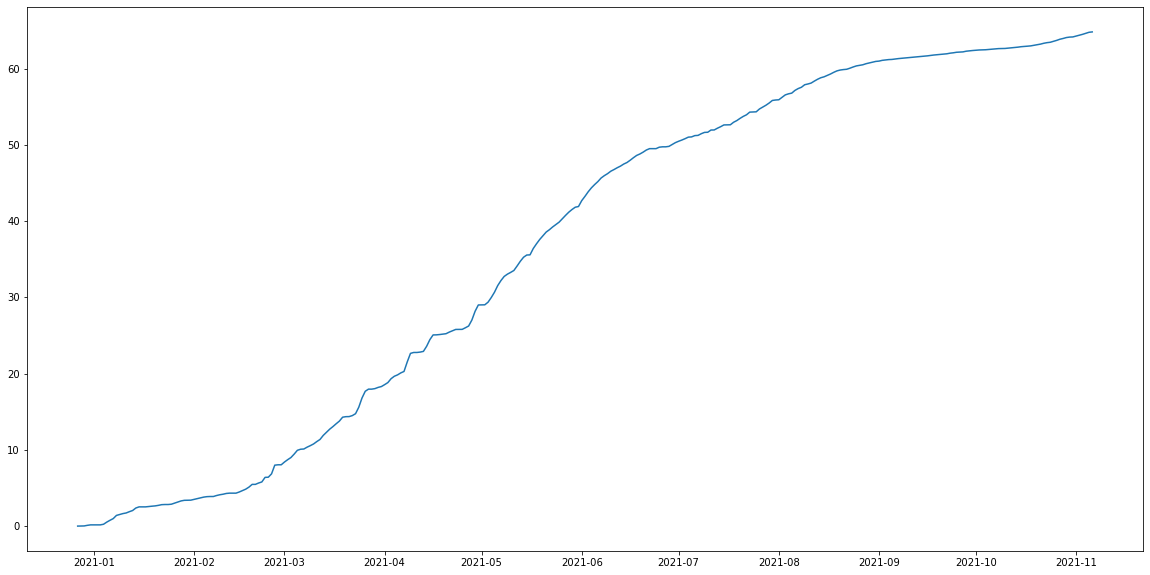

In [108]:
plt.plot(andmed["PopulationCoverage"])

In [109]:
andmed = andmed.sort_index(ascending=True,axis=0)

data = pd.DataFrame(index=range(0,len(andmed)),columns=['StatisticsDate','PopulationCoverage'])

for i in range(0,len(data)):
    data["StatisticsDate"][i] = andmed['StatisticsDate'][i]
    data["PopulationCoverage"][i] = andmed['PopulationCoverage'][i]
    
data.head()

,StatisticsDate,PopulationCoverage
0,2020-12-27 00:00:00,0.02
1,2020-12-28 00:00:00,0.03
2,2020-12-29 00:00:00,0.04
3,2020-12-30 00:00:00,0.12
4,2020-12-31 00:00:00,0.18


In [110]:
#Min-Max Scaler

scaler = MinMaxScaler(feature_range=(0,1))

data.index=data.StatisticsDate
data.drop("StatisticsDate",axis=1,inplace=True)

final_data = data.values
training = final_data[0:240,:]
testing = final_data[240:,:]

scaler=MinMaxScaler(feature_range=(0,1))

scaled_data=scaler.fit_transform(final_data)
x_train=[]
y_train=[]
for i in range(70, len(training)):
    x_train.append(scaled_data[i-70:i,0])
    y_train.append(scaled_data[i,0])

In [111]:
#Long Short-Term Memory model, we use this because it works good with timestamps

model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(
np.shape(x_train)[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model_data=data[len(data)-len(testing)-70:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

In [112]:
#Training and testing datasets

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(np.asarray(x_train),np.asarray(y_train),epochs=1,batch_size=1,verbose=2)

X_test=[]
for i in range(70,model_data.shape[0]):
    X_test.append(model_data[i-70:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

170/170 - 6s - loss: 0.0059 - 6s/epoch - 34ms/step


In [113]:
#Prediction function, here we use the test data
prediction=model.predict(X_test)
prediction=scaler.inverse_transform(prediction)

<ipython-input-119-3b83264af3ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['Predictions']=prediction


,PopulationCoverage,Predictions
StatisticsDate,,
2021-08-24,60.23,60.447018
2021-08-25,60.37,60.583210
2021-08-26,60.45,60.715248
2021-08-27,60.52,60.842323
2021-08-28,60.66,60.963718
2021-08-29,60.76,61.080853
2021-08-30,60.87,61.193962
2021-08-31,60.96,61.303497
2021-09-01,61.0,61.409416


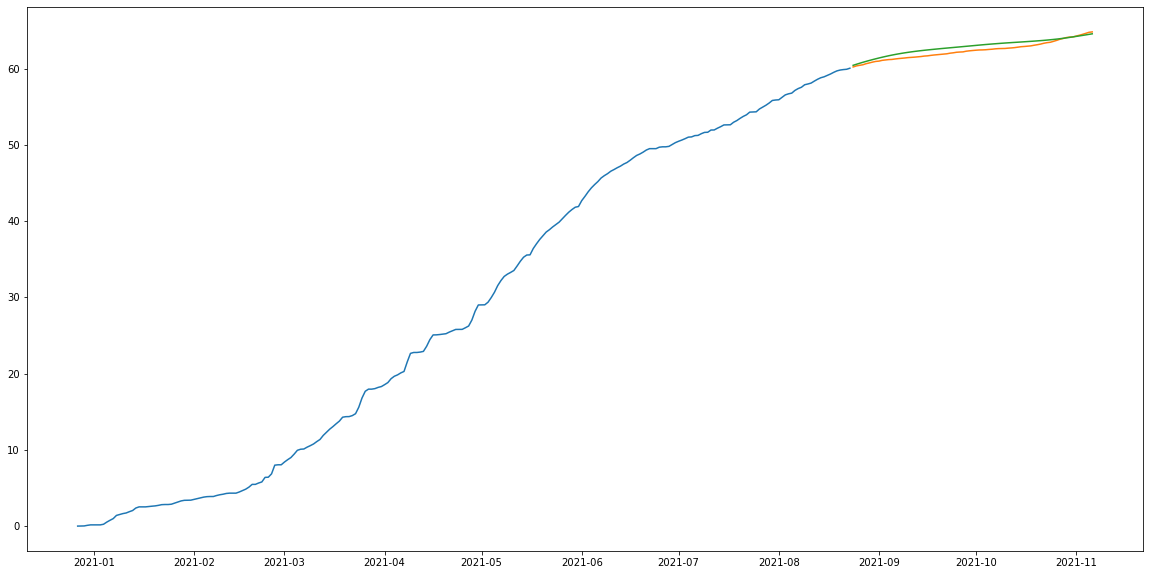

In [119]:
#Now we are seeingg how our prediction compares to the actual output
training=data[:240]
testing=data[240:]
testing['Predictions']=prediction
plt.plot(training["PopulationCoverage"],label="Harjumaa")
plt.plot(testing[["PopulationCoverage","Predictions"]])


testing.head(30)